#Step 1 : Import relevant libraries and packages

In [71]:
from tensorflow.keras.datasets import cifar10

import numpy as np
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from PIL import Image

#Step 2 : Loading CIFAR10 dataset
The CIFAR-10 dataset contains 60,000 color images of dimension 32 X 32 in 3 channels divided into 10 classes. The training data has 50,000 images and the test data has 10,000. You can read more about the dataset here: https://www.cs.toronto.edu/~kriz/cifar.html This is a multi-label image classification problem with 10 labels.

In [72]:
(train_images, train_labels),(test_images, test_labels) = keras.datasets.cifar10.load_data()

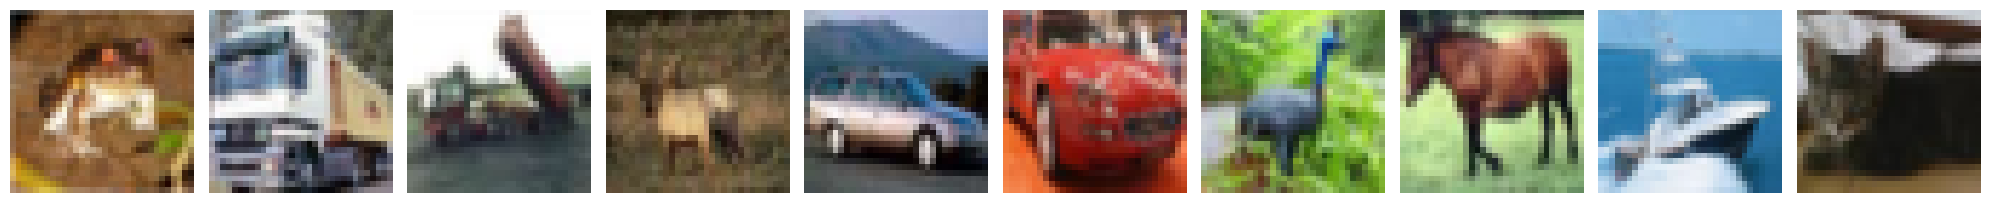

In [73]:
#Define a function to display 10 images from the train or test set
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(train_images[:10])

In [74]:
#Shape of our train and test sets
print("Train images shape : ", train_images.shape)
print("Train labels shape : ", train_labels.shape)

print("Test images shape : ",test_images.shape)
print("Test labels shape : ",test_labels.shape)

Train images shape :  (50000, 32, 32, 3)
Train labels shape :  (50000, 1)
Test images shape :  (10000, 32, 32, 3)
Test labels shape :  (10000, 1)


#Step 3 : Normalize the train and test images
Converting to float and dividing each instance by 255 so that all the image pixels are between 0 and 1

In [75]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

#Step 4 : One hot encode train and test labels
The labels are currently vectors stored as a list with 10 values, all are zero except the correct index for that label will be a 1. Example:

  *Airplane --> [1,0,0,0,0,0,0,0,0,0]
  *Automobile --> [0,1,0,0,0,0,0,0,0,0]
  *Bird --> [0,0,1,0,0,0,0,0,0,0]
We want to split them into separate columns by one hot encoding them

In [76]:
num_classes = 10 
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

#Step 5 : Splitting the train set for a validation set
We will further split the training set to create a validation set to test model results on. We want to make sure that we don't touch the test set till we're happy with our model and are ready to make predictions off the test set.

In [77]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size= 0.2)
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


#Step 6 : Define the CNN Model
The layout of this model is similar to AlexNet designed by Alex Krizhevsky but with different number of filters, kernel_size etc.

We create a Sequential model and start adding layers one by one. The first Conv2D layers are preceeded by MaxPooling2D and Dropout layer. Then 3 Conv2D layers are stacked followed by again a pooling and dropout layer followed by 2 fully connected Dense layers leading to an output layer. The kernel_size and pool_sie are the same through out the network.

The filters double in the size with every layer starting from 128 going up to 512 and coming back down to 256 in the fifth layer. Similar values for neurons were used in the fully connected layer. These settings gave me the best accuracy though it can be computationally expensive. With the help of a GPU on Google colab, I was able to train this model in approximately an hour. I went with the standard activation 'relu' and 'same'padding'

To stop my model from overfitting, I used the l2 kernel_regularizer and also added dropout layers. This reduced overfitting while also icreasing accuracy by a few percent. I again exprimented with a varity of dropout values to land on this one, using lower dropout of 0.3 for the conv layers and a higher 0.5 for the fully connected layers.

In [78]:
def cnn_model():
    
    model = Sequential()
    
    # First Conv layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Second Conv layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Third, fourth, fifth convolution layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected layers
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

#Step 7 : Data Augmentation
Augmenting the training data and introducing random variations of images like rotating them by 15 dgrees, changing width and height etc. made the model generalize better and reduce overfitting while also increasing the accuracy by a bit. It does increase the training time due to the added variations, but is definitely worthwhile training on a GPU.

In [79]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(train_images)


#Step 8 : Intialize the model

In [80]:
model = cnn_model()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 256)        

#Step 9 : Compile the model
Pretty standard settings for the loss, optimizer and metrics functions. I did play around with the learning rate a little bit but the idea was to keep it fairly low to let it slowly converge.

In [81]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=0.0003, decay=1e-6),
             metrics=['accuracy'])

#Step 10 : Fit the model
I first tried a lower batch_size of 32 which increase the amount of time for every epoch and also converged to a higher accuracy very slowly. Batch_size of 64 converged the model much faster and also slowly increases the model accuracy by a bit at the end.

Started with 100 epochs but increased it to 125 as the model was slowly converging still at 100 epochs. Overfitting was not a concern as I had applied strong regluarization. If you look at the output below, the model is beginning to achieve 80% accuracy on the validation set around 30-35 epochs, and the convergence after that is very slow.

In [83]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 64),
                    steps_per_epoch = len(train_images) // 64, 
                    epochs = 125, 
                    validation_data= (val_images, val_labels),
                    verbose=1)

Epoch 1/125
625/625 [==============================] - 34s 54ms/step - loss: 2.0858 - accuracy: 0.2065 - val_loss: 1.8113 - val_accuracy: 0.3418
Epoch 2/125
625/625 [==============================] - 34s 54ms/step - loss: 1.7194 - accuracy: 0.3596 - val_loss: 1.4575 - val_accuracy: 0.4552
Epoch 3/125
625/625 [==============================] - 33s 53ms/step - loss: 1.5154 - accuracy: 0.4544 - val_loss: 1.2780 - val_accuracy: 0.5434
Epoch 4/125
625/625 [==============================] - 32s 51ms/step - loss: 1.3961 - accuracy: 0.5131 - val_loss: 1.1862 - val_accuracy: 0.5860
Epoch 5/125
625/625 [==============================] - 32s 51ms/step - loss: 1.2872 - accuracy: 0.5598 - val_loss: 1.2065 - val_accuracy: 0.5933
Epoch 6/125
625/625 [==============================] - 33s 53ms/step - loss: 1.2262 - accuracy: 0.5877 - val_loss: 1.0626 - val_accuracy: 0.6425
Epoch 7/125
625/625 [==============================] - 33s 53ms/step - loss: 1.1697 - accuracy: 0.6092 - val_loss: 0.9769 - val_ac

#Step 11 : Plotting the train(accuracy and loss) and validation(accuracy and loss)

<Axes: >

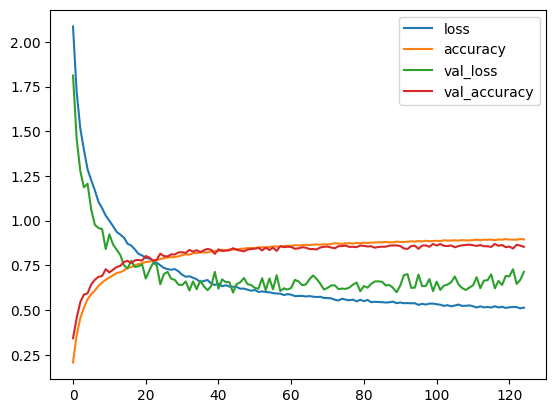

In [84]:
pd.DataFrame(history.history).plot()

#Step 12 : Evaluating the model on the test set

In [85]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.7416 - accuracy: 0.8483


[0.7416495680809021, 0.8482999801635742]

#Step 13 : Make predictions

In [86]:
pred = model.predict(test_images)

313/313 [==============================] - 2s 4ms/step


In [87]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
label_pred = np.argmax(pred, axis= 1)
label_true = np.argmax(test_labels, axis= 1)
errors = label_pred - label_true != 0

#Step 14 : Print Classification Report
This gives us a breaksdown of scores per label. We can see from the report below that our model has learned classifiying airplane, automobile, horse and ship with a 90% precision and recall, and around 73-90% on all the other categories 

In [88]:
print(classification_report(label_true,label_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1000
           1       0.90      0.96      0.93      1000
           2       0.85      0.81      0.83      1000
           3       0.79      0.62      0.69      1000
           4       0.85      0.84      0.84      1000
           5       0.83      0.76      0.79      1000
           6       0.73      0.96      0.83      1000
           7       0.90      0.89      0.90      1000
           8       0.94      0.90      0.92      1000
           9       0.82      0.94      0.88      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



#Step 15 : Check the predictions

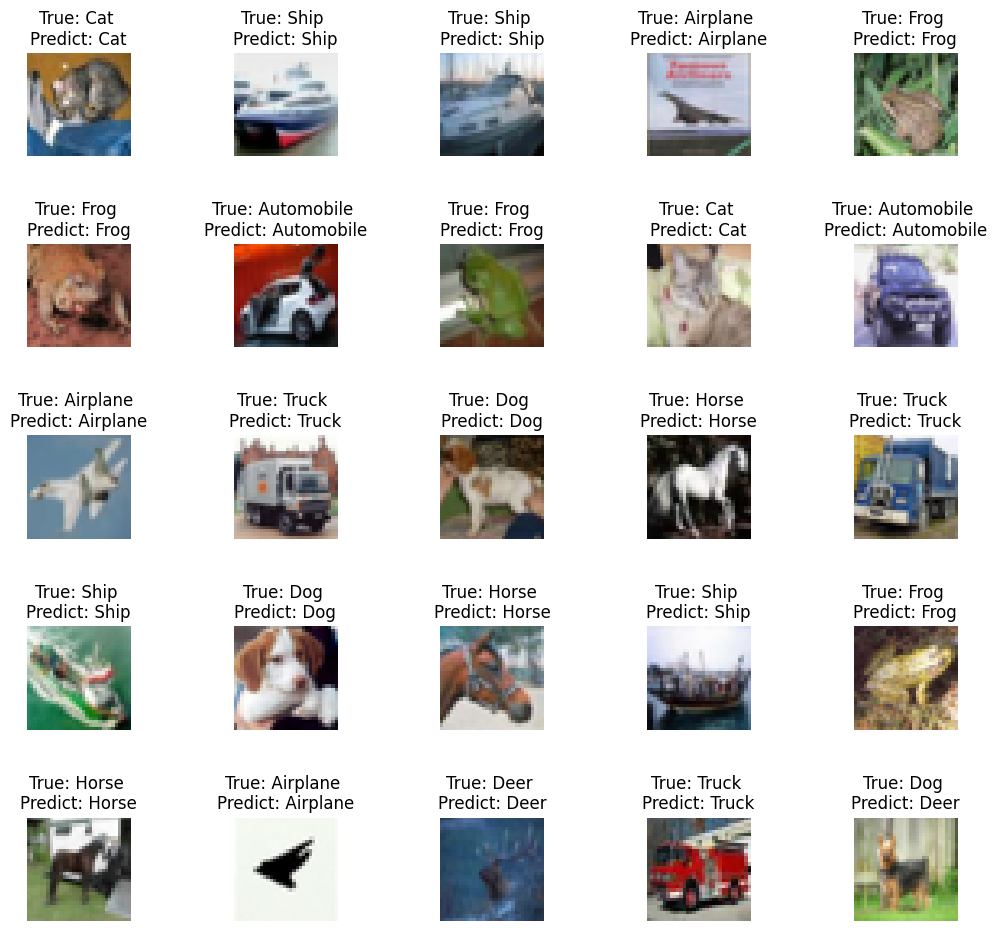

In [91]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
  axes[i].imshow(test_images[i])
  axes[i].set_title('True: %s \nPredict: %s' % (labels[label_true[i]], labels[label_pred[i]]))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)


#Step 16 : Check the wrong predictions

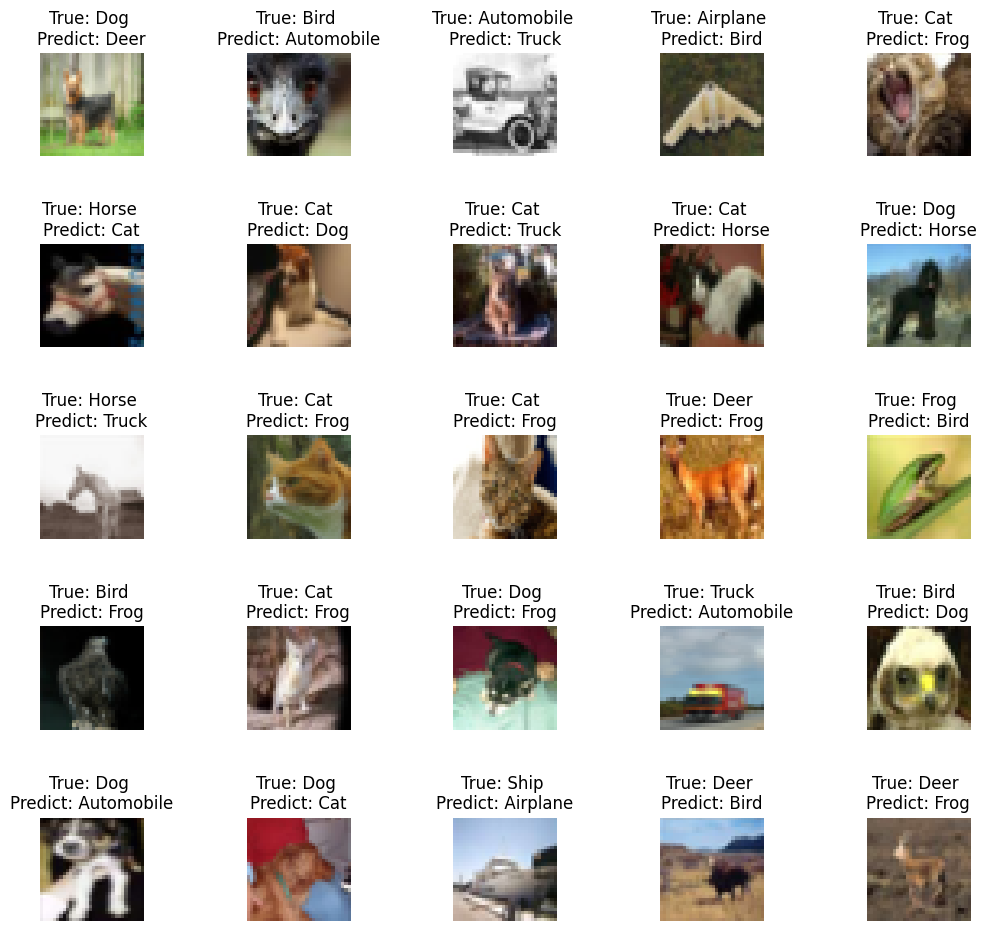

In [92]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

miss_pred = np.where(label_pred != label_true)[0]
for i in np.arange(25):
    axes[i].imshow(test_images[miss_pred[i]])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[label_true[miss_pred[i]]], labels[label_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#Conclusion : As can see from the pictures above that our model is performing pretty well, all the misclassified images can also be easily misclassified by humans as well. They are to a large extent similar to the mislcassfied prediction.

#Step 17 : Save the model
Always save the model and weights so that we can use this trained model and experiment with different parameters to recreate it.

In [93]:
model.save('cifar10_cnn.h5')